Notebook to reproduce key results of 'quasi-Monte Carlo graph random features' paper (https://arxiv.org/abs/2305.12470). Using a new QMC scheme that anticorrelates the lengths of random walks on a graph, we can improve the convergence of MC estimators of graph kernels.

In [1]:
# rf_construction
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 27 13:53:39 2023

@author: ir337
"""
import numpy as np
import random as rnd
import time
from numpy import array, zeros, diag, diagflat, dot
from math import sqrt
import pprint
import scipy
import scipy.linalg

def create_rf_vector(adj_lists, weight_lists, base_vertex,
                     p_halt, nb_random_walks):
  "create RF vector when we're using iid coupling"
  nb_vertices = len(adj_lists)
  rf_vector = np.zeros(nb_vertices)   #initialise container for RF vector
  for _ in range(nb_random_walks):  
    load = 1.0    #initialise load
    current_vertex = base_vertex    #set walker vertex to starting vertex
    rf_vector[current_vertex] += load   
    if adj_lists[current_vertex] == []:
      return rf_vector
    while (rnd.uniform(0,1) > p_halt):   #draw termination random variables, see if terminates     
        rnd_index = int(rnd.uniform(0,1) * len(adj_lists[current_vertex]))   #choose a neighbouring vertex at random
        multiplier = len(adj_lists[current_vertex])    #get degree of current vertex
        load *= weight_lists[current_vertex][rnd_index]   #update load
        load *= multiplier / (1.0 - p_halt)
        current_vertex = adj_lists[current_vertex][rnd_index]   #update vertex
        rf_vector[current_vertex] += load   #update RF vector
  rf_vector /= nb_random_walks    #normalise by no. random walks
  return rf_vector


def create_antithetic_rf_vector(adj_lists, weight_lists, base_vertex,
                     p_halt, nb_random_walks):
  "creates RF vector when we're using antithetic termination"
  nb_vertices = len(adj_lists) 
  rf_vector = np.zeros(nb_vertices)
  if nb_random_walks%2 != 0:
      raise Exception('Need an even number of walks for antithetic coupling')  #check that possible to pair up walkers
  for _ in range(int(nb_random_walks/2)):
    term_indicator1 = 0   #initialise two termination indicators
    term_indicator2 = 0
    load1 = 1.0   #and two loads
    load2 = 1.0
    current_vertex1 = base_vertex   #and two vertex holder variables
    current_vertex2 = base_vertex
    rf_vector[current_vertex1] += load1
    rf_vector[current_vertex2] += load2
    if adj_lists[current_vertex1] == []:
      return rf_vector
    while term_indicator1 == 0 or term_indicator2 == 0:
        rand_draw1 = rnd.uniform(0,1)
        rand_draw2 = np.mod(rand_draw1+0.5,1)   #second termination RV is offset from first by 1/2 modulo 1 (see Eq. 11)
       
        if term_indicator1 ==0:
            term_indicator1 = rand_draw1 < p_halt
        if term_indicator2 == 0:
            term_indicator2 = rand_draw2 < p_halt
           
        if term_indicator1 ==0:     #do updates to load, vertex position and RF vector for first walker
            rnd_index1 = int(rnd.uniform(0,1) * len(adj_lists[current_vertex1]))
            multiplier1 = len(adj_lists[current_vertex1])
            load1 *= weight_lists[current_vertex1][rnd_index1]
            load1 *= multiplier1 / (1.0 - p_halt)
            current_vertex1 = adj_lists[current_vertex1][rnd_index1]
            rf_vector[current_vertex1] += load1
           
        if term_indicator2 ==0:   #likewise for second walker
            rnd_index2 = int(rnd.uniform(0,1) * len(adj_lists[current_vertex2]))
            multiplier2 = len(adj_lists[current_vertex2])
            load2 *= weight_lists[current_vertex2][rnd_index2]
            load2 *= multiplier2 / (1.0 - p_halt)
            current_vertex2 = adj_lists[current_vertex2][rnd_index2]
            rf_vector[current_vertex2] += load2
       
  rf_vector /= nb_random_walks    #normalise by no. walkers
  return rf_vector

def create_lr_fact_of_squared_inv_id_min_w(adj_lists, weight_lists,
                                           p_halt,
                                           nb_random_walks,term_coupling = None):
  "create lr factorisation of matrix using specified coupling. Estimating (1 - U)^{-2}"  
  rf_vectors = []
  for vertex in range(len(adj_lists)):
    if term_coupling == None:   #if no coupling specified, use i.i.d. walkers
        rf_vector = create_rf_vector(adj_lists, weight_lists,
                                 vertex, p_halt, nb_random_walks)
    
    elif term_coupling == 'antithetic':   #else use antithetic termination
        rf_vector = create_antithetic_rf_vector(adj_lists, weight_lists,
                                 vertex, p_halt, nb_random_walks)
      
    else:
       raise Exception('Coupling scheme not recognised. Either set to None or \'antithetic\'')

    rf_vectors.append(rf_vector)

  A_matrix = np.array(rf_vectors)   #convert stacked random feature vectors to a matrix
  B_matrix = np.transpose(A_matrix)   #return this matrix and its transpose
  
  return A_matrix, B_matrix

In [2]:
# utils

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 27 11:24:18 2023

@author: ir337
"""

import numpy as np
import random as rnd
import time
from numpy import array, zeros, diag, diagflat, dot
from math import sqrt
import pprint
import scipy
import scipy.linalg



def get_laplacian_matrix(W):
    "to get the (normalised?) graph Laplacian from adj matrix"
    nb_vertices = len(W)
    L = 0.5 * np.eye(nb_vertices) # np.eye returns a 2-D array with ones on the diagonal and zeros elsewhere, nb_vertices = # rows and # cols
    degrees = np.sum(W,axis=1) # degree matrix
    for i in range(nb_vertices):
        for j in range(i):
            L[i,j] = - W[i,j]/np.sqrt(degrees[i] * degrees[j]) 
    L += L.T # transpose
    return L

def get_unnormalised_laplacian_matrix(W):
    "to get the graph Laplacian from adj matrix"
    nb_vertices = len(W)
    degrees = np.sum(W,axis=1)
    return np.diag(degrees) - W
   
def get_exact_evaluation(A):
    "to calculate th exact form of the matrix"
    nb_vertices = len(A)
    M = np.eye(nb_vertices) - A
    M2 = np.matmul(M,M)
    M2I = np.linalg.inv(M2)   
    return M2I

def adj_matrix_to_lists(A):
  "takes a matrix and returns lists of neighbours and edge weights"
  adj_lists = []
  weight_lists = []

  for i in range(len(A)):
    neighbors = []
    weights = []
    for j in range(len(A[i])):
      if A[i][j] != 0.0:
        neighbors.append(j)
        weights.append(A[i][j])
    adj_lists.append(neighbors)
    weight_lists.append(weights)
    
  return adj_lists, weight_lists

def compute_fro(first_matrix, second_matrix, relative=True):
  "calculates the Frobenius norm"  
  diff_norm = np.linalg.norm(first_matrix - second_matrix)
  if not relative:
    return diff_norm * diff_norm
  else:
    return diff_norm / np.linalg.norm(first_matrix)


In [12]:
# matern kernel

from scipy.sparse.csgraph import shortest_path
from scipy.special import kv, gamma

def matern_kernel(adjacency_matrix, nu=1.5, length_scale=1.0):
    # Compute the Matérn kernel
    # nu = smoothness parameter
    # length_scale = length scale parameter
    r = shortest_path(adjacency_matrix, method='D')
    factor = (2 ** (1.0 - nu)) / gamma(nu)
    scaled_r = (np.sqrt(2 * nu) * r) / length_scale
    matern = factor * (scaled_r ** nu) * kv(nu, scaled_r)
    matern[r == 0] = 1  # Handle the case where r is 0 (i.e., diagonal elements)
    return matern

In [15]:
# diffusion kernel

from scipy.linalg import expm

def adjacency_to_laplacian(adjacency_matrix):
    # Degree matrix
    degrees = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degrees)
    # Laplacian matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    return laplacian_matrix

def diffusion_kernel(adjacency_matrix, t=1.0):
    # Convert adjacency matrix to Laplacian matrix
    laplacian_matrix = adjacency_to_laplacian(adjacency_matrix)
    # Compute the diffusion kernel
    kernel = expm(-t * laplacian_matrix)
    return kernel

In [18]:
# inverse cosine kernel

from numpy.linalg import norm

def adjacency_to_cosine_similarity(adjacency_matrix):
    # Compute cosine similarity matrix
    similarity_matrix = adjacency_matrix @ adjacency_matrix.T
    norms = norm(adjacency_matrix, axis=1)
    cosine_similarity_matrix = similarity_matrix / (norms[:, None] * norms[None, :])
    return cosine_similarity_matrix

def inverse_cosine_kernel(adjacency_matrix):
    # Convert adjacency matrix to cosine similarity matrix
    cosine_similarity_matrix = adjacency_to_cosine_similarity(adjacency_matrix)
    # Compute the inverse cosine kernel (element-wise inverse)
    kernel_matrix = 1 - cosine_similarity_matrix
    return kernel_matrix

In [3]:
import numpy as np
import random as rnd
import time
import matplotlib
from matplotlib import pyplot as plt
from numpy import array, zeros, diag, diagflat, dot
from math import sqrt
import pprint
import scipy
import scipy.linalg
import os
from tqdm import tqdm
# from utils import *
# from rf_construction import *
import pickle

In [4]:
# os.chdir('/homes/ir337/Documents/antithetic_termination_final')
os.chdir('C:/Summer programs/summer 2024/illinois tech SURE REU/research/applications in graph theory/code')

In [5]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [6]:
#load adjacency matrix arrays for the graphs to be considered
with open('adjacency_matrices.pkl','rb') as f:
    As = pickle.load(f)

In [19]:
## using inverse cosine kernel

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = inverse_cosine_kernel(A) 
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 5149.35it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 3043.23it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1996.21it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1757.00it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1099.00it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 649.16it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 601.71it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 426.31it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 300.91it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 285.90it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 176.14it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 101.14it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 265.87it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 198.56it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 120.95it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 137.14it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 63.92it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 601.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 394.05it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 305.47it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 296.03it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 171.31it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 110.47it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 4883.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2206.02it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1060.64it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1116.39it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 707.81it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 379.52it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1585.22it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1394.42it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 633.56it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 701.80it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 319.28it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 197.69it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 409.37it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 211.48it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 121.28it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 114.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 82.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 61.89it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

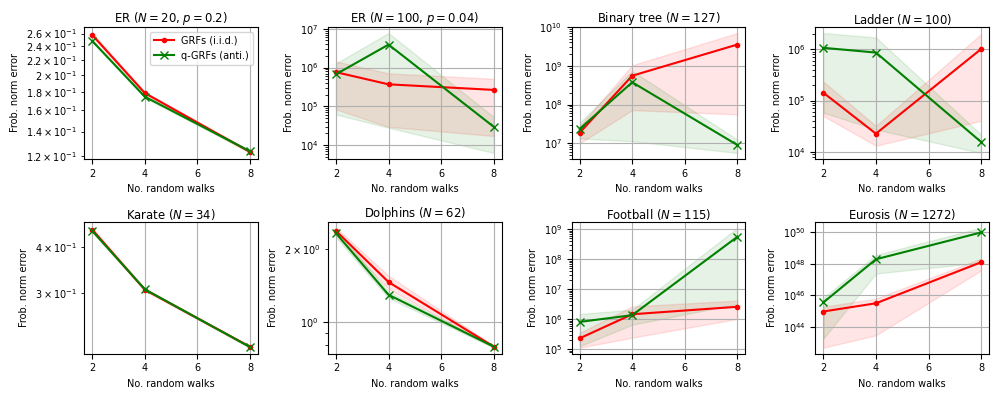

In [20]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

In [16]:
## using diffusion kernel

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = diffusion_kernel(A) 
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 4453.69it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 4933.72it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1909.87it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1821.00it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1055.65it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 607.02it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 558.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 360.96it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 292.35it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 241.20it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 188.06it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 108.77it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 299.12it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 159.44it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 142.52it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 128.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 107.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 64.14it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 638.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 355.99it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 303.47it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 316.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 187.65it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 114.32it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2998.57it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2925.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1412.44it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 591.47it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 573.64it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 290.83it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2119.25it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1267.88it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 682.71it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 575.70it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 319.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 171.81it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 264.98it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 200.44it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 150.17it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 153.74it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 104.45it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 70.09it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:06<00:00, 14.32it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:17<00:00,  5.69it/s]

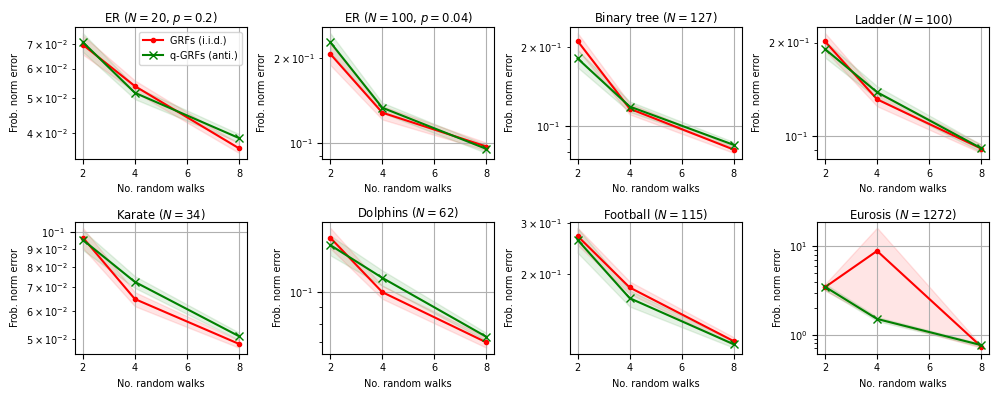

In [17]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

In [13]:
## using matern_kernel function

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = matern_kernel(A)  
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

C:\Users\waine\AppData\Local\Temp\ipykernel_21216\3641155174.py:11: RuntimeWarning: invalid value encountered in multiply
  matern = factor * (scaled_r ** nu) * kv(nu, scaled_r)


Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 3021.11it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 3031.73it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2096.41it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1998.76it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1004.76it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 536.71it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 642.13it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 448.08it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 283.37it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 292.18it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 187.52it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 105.39it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 241.02it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 189.59it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 141.60it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 141.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.76it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 64.23it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 612.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 416.67it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 263.69it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 286.09it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 173.97it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 112.30it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 3332.99it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2125.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 749.55it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1334.57it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 650.24it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 336.60it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2040.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1378.04it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 531.11it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 570.96it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 344.39it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 185.89it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 303.22it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 193.06it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 128.04it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 139.83it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 50.53it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:13<00:00,  7.58it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]

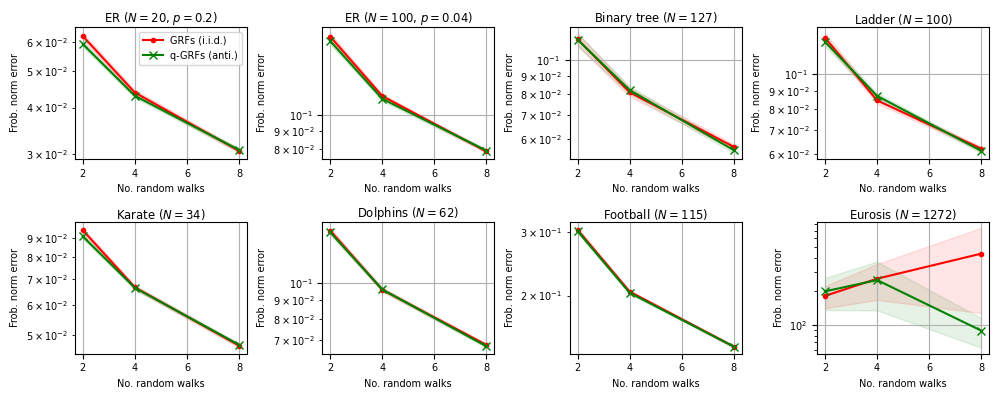

In [14]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

In [9]:
## using get_unnormalised_laplacian_matrix function

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = get_unnormalised_laplacian_matrix(A) 
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 4010.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 3462.48it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1918.57it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1636.80it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 987.68it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 603.79it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 688.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 496.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 324.74it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 307.13it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 196.00it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 102.92it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 309.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 207.99it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 181.35it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.05it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 126.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 70.59it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 630.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 456.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 272.10it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 272.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 168.65it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 98.75it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 3543.38it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1917.84it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 997.72it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1113.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 543.11it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 309.65it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2147.36it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1166.12it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 631.31it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 637.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 332.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 178.86it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 410.66it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 298.56it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 223.44it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 185.13it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 113.61it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 74.66it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]

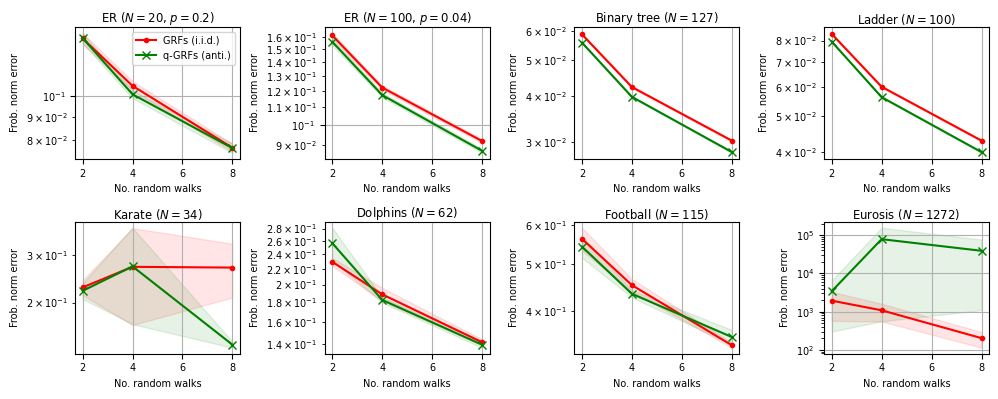

In [10]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

In [7]:
## using get_laplacian_matrix function

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = get_laplacian_matrix(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')



Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 5813.88it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 5929.60it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2013.35it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 3010.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1472.26it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 858.89it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 628.03it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 523.81it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 377.07it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 381.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 227.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 133.59it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 546.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 344.89it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 203.48it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 182.98it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 127.80it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 81.06it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 774.46it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 515.00it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 347.19it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 351.65it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 217.47it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 131.47it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 6385.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 3035.08it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1553.42it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1290.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1141.28it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 513.02it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2532.30it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2021.14it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 991.98it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 995.16it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 575.92it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 313.71it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 284.56it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 123.82it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 92.33it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 89.38it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:02<00:00, 49.82it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]

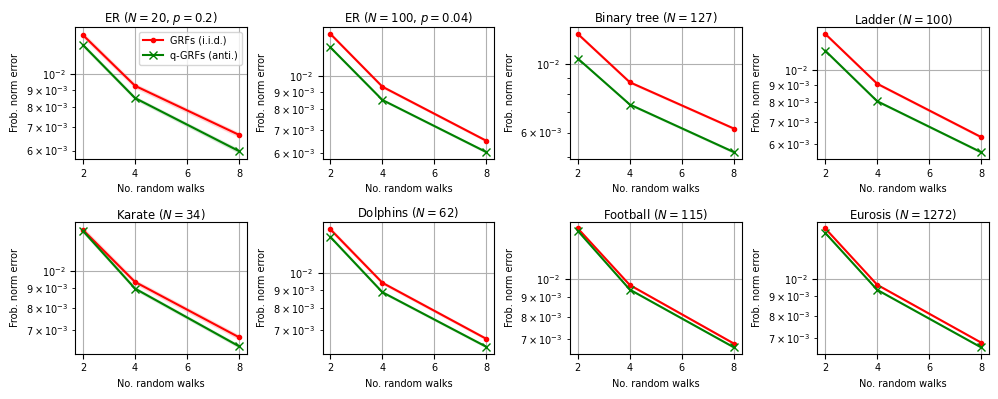

In [8]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()